In [1]:
PROJECT_ID = "formazione-riccardo-zanella" #@param {type: "string"}
REGION = 'us-central1' #@param {type: "string"}
BUCKET_NAME = "bbs-2021-opml4b-explainability" #@param {type:"string"}

## Build, train, and evaluate your model with Keras

This section shows how to build, train, evaluate, and get local predictions from a model by using the Keras [Sequential API](https://www.tensorflow.org/guide/keras/sequential_model). The model will takes your 10 features as input and predict the trip duration in minutes.

In [2]:
import tensorflow as tf
import pandas as pd

2021-10-22 14:33:49.308334: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-22 14:33:49.308374: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [17]:
TRAIN_FILE = 'gs://'+BUCKET_NAME+'/data/train.csv'
TEST_FILE = 'gs://'+BUCKET_NAME+'/data/test.csv'
EXPORT_PATH = 'gs://' + BUCKET_NAME + '/explanations/mymodel'

In [6]:
with tf.io.gfile.GFile(TRAIN_FILE) as f:
    train_data = pd.read_csv(f)

with tf.io.gfile.GFile(TEST_FILE) as f:
    test_data = pd.read_csv(f)

In [8]:
from typing import Tuple

def split_features_labels(dframe: pd.DataFrame, label_col: str = 'duration') -> Tuple[pd.DataFrame]:
    labels = dframe[label_col]
    features = dframe.drop(columns=[label_col])
    return features, labels


In [9]:
train_data, train_labels = split_features_labels(train_data)

test_data, test_labels = split_features_labels(test_data)

In [10]:
# Build your model
model = tf.keras.Sequential(name="bike_predict")
model.add(tf.keras.layers.Dense(64, input_dim=len(train_data.iloc[0]), activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1))

2021-10-22 14:38:56.351778: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-22 14:38:56.351815: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-22 14:38:56.351831: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (INJ-NB-126): /proc/driver/nvidia/version does not exist
2021-10-22 14:38:56.351988: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# Compile the model and see a summary
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='mean_squared_logarithmic_error', optimizer=optimizer)
model.summary()

Model: "bike_predict"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                704       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________


### Create an input data pipeline with tf.data

In [12]:
batch_size = 256
epochs = 3

input_train = tf.data.Dataset.from_tensor_slices(train_data)
output_train = tf.data.Dataset.from_tensor_slices(train_labels)
input_train = input_train.batch(batch_size).repeat()
output_train = output_train.batch(batch_size).repeat()
train_dataset = tf.data.Dataset.zip((input_train, output_train))

### Train the model

In [13]:
# This will take about a minute to run
# To keep training time short, you're not using the full dataset
train_size = len(train_data)
model.fit(train_dataset, steps_per_epoch=train_size // batch_size, epochs=epochs)

Epoch 1/3
  69/2958 [..............................] - ETA: 4s - loss: 2.0662

2021-10-22 14:39:58.528991: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2958/2958 [==============================] - 5s 1ms/step - loss: 0.7057
Epoch 2/3
2958/2958 [==============================] - 4s 1ms/step - loss: 0.3599
Epoch 3/3
2958/2958 [==============================] - 4s 1ms/step - loss: 0.3608


### Evaluate the trained model locally

In [14]:
# Run evaluation
results = model.evaluate(test_data, test_labels)
print(results)

5917/5917 [==============================] - 4s 625us/step - loss: 0.3549
0.3549324870109558


In [15]:
# Send test instances to model for prediction
predict = model.predict(test_data[:5])

In [16]:
# Preview predictions on the first 5 examples from your test dataset
for i, val in enumerate(predict):
    print('Predicted duration: {}'.format(round(val[0])))
    print('Actual duration: {} \n'.format(test_labels.iloc[i]))

Predicted duration: 18
Actual duration: 22.0 

Predicted duration: 27
Actual duration: 31.0 

Predicted duration: 27
Actual duration: 23.0 

Predicted duration: 17
Actual duration: 14.0 

Predicted duration: 12
Actual duration: 9.0 



## Export the model as a TF 2.x SavedModel

When using TensorFlow 2.x, you export the model as a `SavedModel` and load it into Cloud Storage. 

In [19]:
model.save(EXPORT_PATH)
print(EXPORT_PATH)

2021-10-22 14:41:16.906603: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: gs://bbs-2021-opml4b-explainability/explanations/mymodel/assets
gs://bbs-2021-opml4b-explainability/explanations/mymodel


Use TensorFlow's `saved_model_cli` to inspect the model's SignatureDef. You'll use this information when you deploy your model to AI Explanations in the next section.

In [22]:
! saved_model_cli show --dir $EXPORT_PATH --all

2021-10-22 14:41:59.205271: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-22 14:41:59.205311: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['dense_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: serving_def

## Deploy the model to AI Explanations

In order to deploy the model to Explanations, you need to generate an `explanations_metadata.json` file and upload this to the Cloud Storage bucket with your SavedModel. Then you'll deploy the model using `gcloud`.

### Prepare explanation metadata

In order to deploy this model to AI Explanations, you need to create an explanation_metadata.json file with information about your model inputs, outputs, and baseline. You can use the [Explainable AI SDK](https://pypi.org/project/explainable-ai-sdk/) to generate most of the fields. 

The value for `input_baselines` tells the explanations service what the baseline input should be for your model. Here you're using the median for all of your input features. That means the baseline prediction for this model will be the trip duration your model predicts for the median of each feature in your dataset. 

Since this model accepts a single numpy array with all numerical feature, you can optionally pass an `index_feature_mapping` list to AI Explanations to make the API response easier to parse. When you provide a list of feature names via this parameter, the service will return a key / value mapping of each feature with its corresponding attribution value.

In [21]:
# Print the names of your tensors
print('Model input tensor: ', model.input.name)
print('Model output tensor: ', model.output.name)

Model input tensor:  dense_input
Model output tensor:  dense_2/BiasAdd:0


In [19]:
from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder
builder = SavedModelMetadataBuilder(export_path)
builder.set_numeric_metadata(
    model.input.name.split(':')[0],
    input_baselines=[train_data.median().values.tolist()],
    index_feature_mapping=train_data.columns.tolist()
)
builder.save_metadata(export_path)

Since this is a regression model (predicting a numerical value), the baseline prediction will be the same for every example you send to the model. If this were instead a classification model, each class would have a different baseline prediction.

### Create the model

In [20]:
MODEL = 'bike'

In [ ]:
# Create the model if it doesn't exist yet (you only need to run this once)
! gcloud ai-platform models create $MODEL --enable-logging --region=$REGION

### Create the model version 

Creating the version will take ~5-10 minutes. Note that your first deploy could take longer.

In [23]:
# Each time you create a version the name should be unique
VERSION = 'v1'

In [21]:
# Create the version with gcloud
explain_method = 'integrated-gradients'
! gcloud beta ai-platform versions create $VERSION --region=$REGION \
--model $MODEL \
--origin $export_path \
--runtime-version 2.1 \
--framework TENSORFLOW \
--python-version 3.7 \
--machine-type n1-standard-4 \
--explanation-method $explain_method \
--num-integral-steps 25

ERROR: (gcloud.beta.ai-platform.versions.create) Invalid choice: ''.
This command is available in one or more alternate release tracks.  Try:
  gcloud ai-platform versions create
  gcloud alpha ai-platform versions create


In [24]:
# Make sure the model deployed correctly. State should be `READY` in the following log
! gcloud ai-platform versions describe $VERSION --region $REGION --model $MODEL

Using endpoint [https://us-central1-ml.googleapis.com/]
createTime: '2021-10-22T10:04:19Z'
deploymentUri: gs://bbs-2021-opml4b-explainability/explanations/mymodel
etag: aEdkYSb45jQ=
explanationConfig:
  integratedGradientsAttribution:
    numIntegralSteps: 25
framework: TENSORFLOW
isDefault: true
lastUseTime: '2021-10-22T10:19:16Z'
machineType: n1-standard-4
name: projects/formazione-riccardo-zanella/models/bike/versions/v1
pythonVersion: '3.7'
runtimeVersion: '2.1'
state: READY


## Get predictions and explanations

Now that your model is deployed, you can use the AI Platform Prediction API to get feature attributions. You'll pass it a single test example here and see which features were most important in the model's prediction. Here you'll use the [Explainable AI SDK](https://pypi.org/project/explainable-ai-sdk/) to get your prediction and explanation. You can also use `gcloud`.

### Format your explanation request

To make your AI Explanations request, you need to create a JSON object with your test data for prediction.

In [25]:
# Format data for prediction to your model
prediction_json = {model.input.name.split(':')[0]: test_data.iloc[0].values.tolist()}

### Send the explain request

You can use the Explainable AI SDK to send explanation requests to your deployed model.

In [26]:
import explainable_ai_sdk
remote_ig_model = explainable_ai_sdk.load_model_from_ai_platform(PROJECT_ID, MODEL, VERSION, region=REGION)
ig_response = remote_ig_model.explain([prediction_json])

### Understanding the explanations response

First, let's look at the trip duration your model predicted and compare it to the actual value

In [27]:
attr = ig_response[0].get_attribution()

predicted = round(attr.example_score, 2)
print('Predicted duration: ' + str(predicted) + ' minutes')
print('Actual duration: ' + str(test_labels.iloc[0]) + ' minutes')

Predicted duration: 16.65 minutes
Actual duration: 22.0 minutes


Next let's look at the feature attributions for this particular example. Positive attribution values mean a particular feature pushed your model prediction up by that amount, and vice versa for negative attribution values.

Label Index 0
Example Score: 16.6543
Baseline Score: 13.0743
Approximation Error: 0.0000


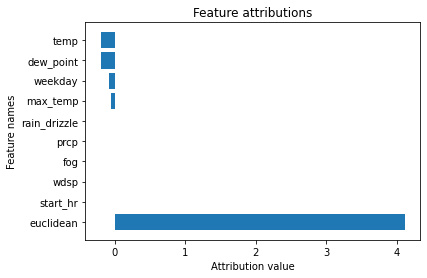

In [28]:
ig_response[0].visualize_attributions()

## Check your explanations and baselines

To better make sense of the feature attributions you're getting, you should compare them with your model's baseline. In most cases, the sum of your attribution values + the baseline should be very close to your model's predicted value for each input. Also note that for regression models, the `baseline_score` returned from AI Explanations will be the same for each example sent to your model. For classification models, each class will have its own baseline.

In this section you'll send 10 test examples to your model for prediction in order to compare the feature attributions with the baseline. Then you'll run each test example's attributions through two sanity checks in the `sanity_check_explanations` method.

In [29]:
# Prepare 10 test examples to your model for prediction
pred_batch = []
for i in range(10):
    pred_batch.append({model.input.name.split(':')[0]: test_data.iloc[i].values.tolist()})

In [30]:
test_response = remote_ig_model.explain(pred_batch)

In the function below you perform two sanity checks for models using Integrated Gradient (IG) explanations and one sanity check for models using Sampled Shapley.

In [31]:
def sanity_check_explanations(example, mean_tgt_value=None, variance_tgt_value=None):
    passed_test = 0
    total_test = 1
    # `attributions` is a dict where keys are the feature names
    # and values are the feature attributions for each feature
    attr = example.get_attribution()
    baseline_score = attr.baseline_score
    # sum_with_baseline = np.sum(attribution_vals) + baseline_score
    predicted_val = attr.example_score

    # Sanity check 1
    # The prediction at the input is equal to that at the baseline.
    #  Please use a different baseline. Some suggestions are: random input, training
    #  set mean.
    if abs(predicted_val - baseline_score) <= 0.05:
        print('Warning: example score and baseline score are too close.')
        print('You might not get attributions.')
    else:
        passed_test += 1

    # Sanity check 2 (only for models using Integrated Gradient explanations)
    # Ideally, the sum of the integrated gradients must be equal to the difference
    # in the prediction probability at the input and baseline. Any discrepency in
    # these two values is due to the errors in approximating the integral.
    if explain_method == 'integrated-gradients':
        total_test += 1
        want_integral = predicted_val - baseline_score
        got_integral = sum(attr.post_processed_attributions.values())
        if abs(want_integral - got_integral) / abs(want_integral) > 0.05:
            print('Warning: Integral approximation error exceeds 5%.')
            print('Please try increasing the number of integrated gradient steps.')
        else:
            passed_test += 1

    print(passed_test, ' out of ', total_test, ' sanity checks passed.')

In [32]:
for response in test_response:
    sanity_check_explanations(response)

2  out of  2  sanity checks passed.
2  out of  2  sanity checks passed.
2  out of  2  sanity checks passed.
2  out of  2  sanity checks passed.
2  out of  2  sanity checks passed.
2  out of  2  sanity checks passed.
2  out of  2  sanity checks passed.
2  out of  2  sanity checks passed.
2  out of  2  sanity checks passed.
2  out of  2  sanity checks passed.


## Understanding AI Explanations with the What-If Tool

In this section you'll use the [What-If Tool](https://pair-code.github.io/what-if-tool/) to better understand how your model is making predictions. See the cell below the What-if Tool for visualization ideas.

The What-If-Tool expects data with keys for each feature name, but your model expects a flat list. The functions below convert data to the format required by the What-If Tool.

In [39]:
# This is the number of data points you'll send to the What-if Tool
WHAT_IF_TOOL_SIZE = 500

from witwidget.notebook.visualization import WitWidget, WitConfigBuilder


def create_list(ex_dict):
    new_list = []
    for i in feature_names:
        new_list.append(ex_dict[i])
    return new_list


def example_dict_to_input(example_dict):
    return {'dense_input': create_list(example_dict)}


from collections import OrderedDict
wit_data = test_data.iloc[:WHAT_IF_TOOL_SIZE].copy()
wit_data['duration'] = test_labels[:WHAT_IF_TOOL_SIZE]
wit_data_dict = wit_data.to_dict(orient='records', into=OrderedDict)

In [40]:
config_builder = WitConfigBuilder(
    wit_data_dict
).set_ai_platform_model(
    PROJECT_ID,
    MODEL,
    VERSION,
    adjust_example=example_dict_to_input
).set_target_feature('duration').set_model_type('regression')

WitWidget(config_builder)

WitWidget(config={'model_type': 'regression', 'label_vocab': [], 'uses_json_input': True, 'inference_address':…

### What-If Tool visualization ideas

On the x-axis, you'll see the predicted trip duration for the test inputs you passed to the What-If Tool. Each circle represents one of your test examples. If you click on a circle, you'll be able to see the feature values for that example along with the attribution values for each feature. 

* You can edit individual feature values and re-run prediction directly within the What-If Tool. Try changing `distance`, click **Run inference** and see how that affects the model's prediction
* You can sort features for an individual example by their attribution value, try changing the sort from the attributions dropdown
* The What-If Tool also lets you create custom visualizations. You can do this by changing the values in the dropdown menus above the scatter plot visualization. For example, you can sort data points by inference error, or by their similarity to a single datapoint.

If your Cloud Storage bucket doesn't contain any other objects and you would like to delete it, run `gsutil rm -r gs://$BUCKET_NAME`.

## What's next?

To learn more about AI Explanations or the What-if Tool, check out the resources here.

* [AI Explanations documentation](cloud.google.com/ml-engine/docs/ai-explanations)
* [Documentation for using the What-if Tool with Cloud AI Platform models ](https://cloud.google.com/ml-engine/docs/using-what-if-tool) 
* [What-If Tool documentation and demos](https://pair-code.github.io/what-if-tool/)
* [Integrated gradients paper](https://arxiv.org/abs/1703.01365)